<a href="https://colab.research.google.com/github/chikum/SiK/blob/AES/36DLAssignment_Vision_SubmissionV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries/Dataset

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.data import TFRecordDataset
from tensorflow.keras import regularizers

(ds_train,ds_test), ds_info = tfds.load('imagenette/160px-v2', split=['train', 'validation'], with_info=True)



In [ ]:
(imagenet_example,) = ds_train.take(1)
img, label = imagenet_example["image"], imagenet_example["label"]
print("Image_shape", img.numpy().shape)
print("Label_shape", label.numpy().shape)

Image_shape (160, 198, 3)
Label_shape ()


In [ ]:
print('Train data shape')
print(tf.data.experimental.cardinality(ds_train))
print('Test data shape')
print(tf.data.experimental.cardinality(ds_test))

Train data shape
tf.Tensor(9469, shape=(), dtype=int64)
Test data shape
tf.Tensor(3925, shape=(), dtype=int64)


Plot at least two samples from each class of the dataset (use matplotlib/seaborn/any other library)

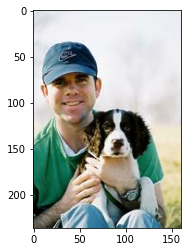

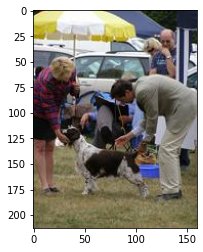

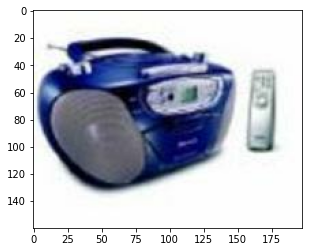

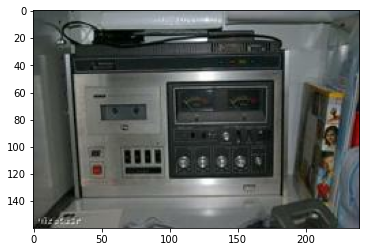

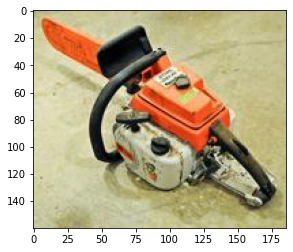

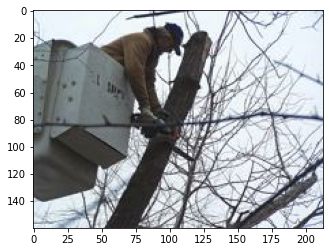

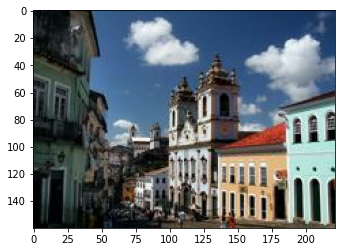

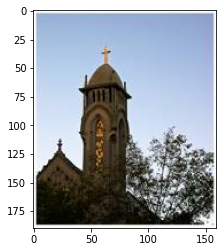

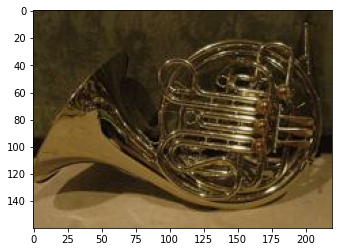

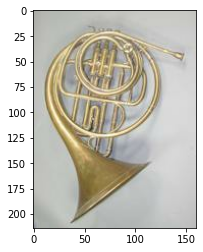

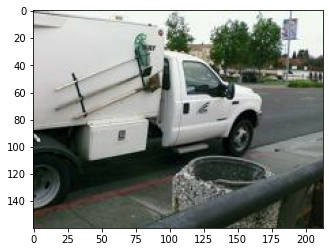

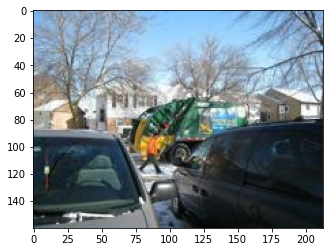

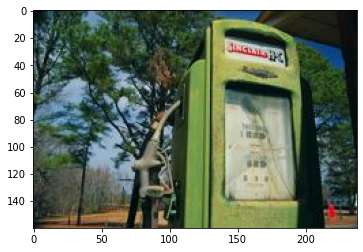

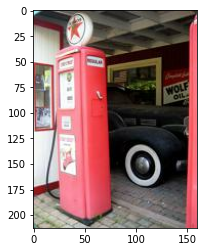

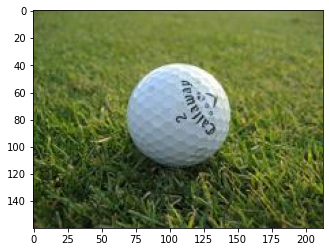

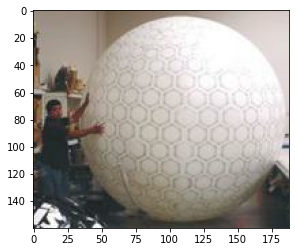

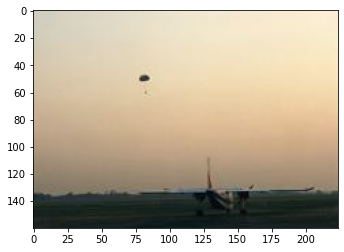

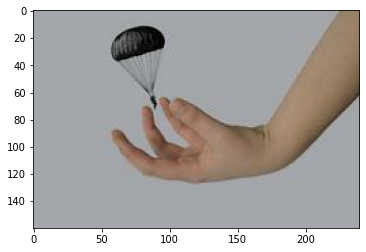

In [ ]:
def plot_n_samples(ds, sample_size, class_label):
  ds_classn = ds.filter(lambda fd: fd['label'] == class_label)
  ds_classn = ds_classn.take(sample_size)
  for sample in ds_classn:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`    
      image = sample["image"]
      label = sample["label"]      
      plt.figure()
      plt.imshow(image)  
      plt.axis('on')

#Find a way to iterate over class numbers
plot_n_samples(ds_train, 2, 1)
plot_n_samples(ds_train, 2, 2)
plot_n_samples(ds_train, 2, 3)
plot_n_samples(ds_train, 2, 4)
plot_n_samples(ds_train, 2, 5)
plot_n_samples(ds_train, 2, 6)
plot_n_samples(ds_train, 2, 7)
plot_n_samples(ds_train, 2, 8)
plot_n_samples(ds_train, 2, 9)
plot_n_samples(ds_train, 2, 10)


Apply rotation and height shift augmentation (rotation_range, height_shift_range) to the dataset separately. Print the augmented image and the original image for each class and each augmentation.

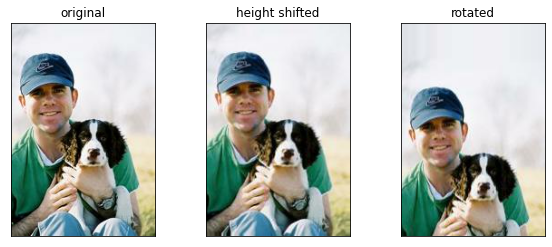

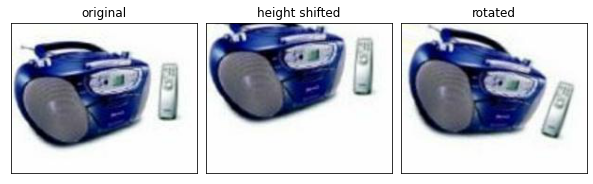

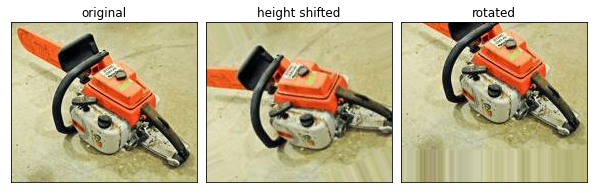

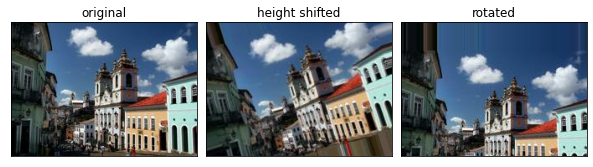

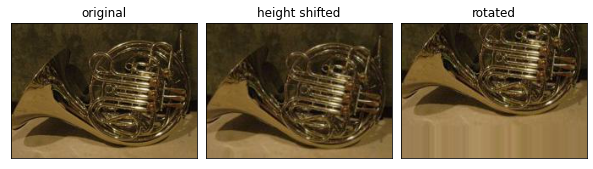

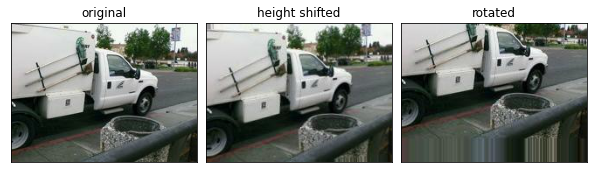

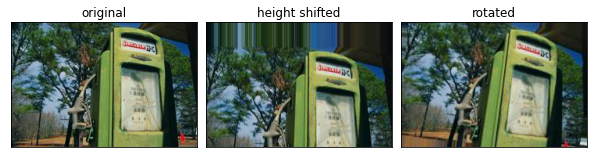

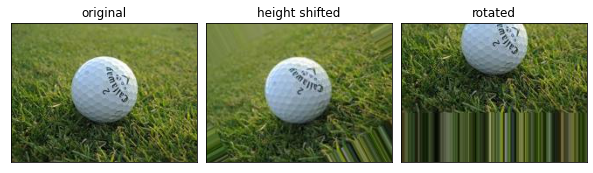

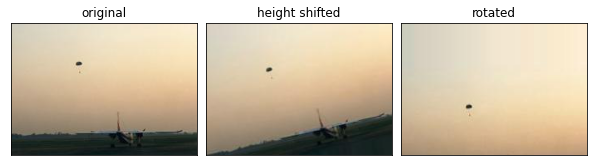

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
def generate_augmented_image(datagen_rotate, datagen_hshift, ds, class_label):
  try:
      ## if the preview folder does not exist, create
      os.mkdir('preview')
  except:
      ## if the preview folder exists, then remove
      ## the contents (pictures) in the folder
      for item in os.listdir('preview'):        
          os.remove('preview' + "/" + item)
  ds = ds.filter(lambda fd: fd['label'] == class_label)
  ds = ds.take(1)
  for example in ds:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}
    image = example["image"]
    x = img_to_array(image)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

    # the .flow() command below generates batches of randomly transformed 4 images
    # and saves the results to the `preview/` directory
    i = 1
    for batch in datagen_rotate.flow(x, batch_size=1,
                        save_to_dir='preview', save_prefix='fullsize', save_format='jpeg'):
      i += 1
      if i > 1:
          break  # otherwise the generator would loop indefinitely
    
    i = 1
    for batch in datagen_hshift.flow(x, batch_size=1,
                        save_to_dir='preview', save_prefix='fullsize', save_format='jpeg'):
      i += 1
      if i > 1:
          break  # otherwise the generator would loop indefinitely

    ## -------------------------- ##
    ##   plot the generated data
    ## -------------------------- ##
    fig = plt.figure(figsize=(8, 6))
    fig.subplots_adjust(hspace=0.02,wspace=0.05,
                    left=0,right=1,bottom=0, top=1.5)

    ## original picture
    ax = fig.add_subplot(3, 3, 1,xticks=[],yticks=[])        
    ax.imshow(image)
    ax.set_title("original")

    i = 2
    for imgnm in os.listdir('preview'):
        ax = fig.add_subplot(3, 3, i,xticks=[],yticks=[]) 
        img = load_img('preview' + "/" + imgnm)
        ax.imshow(img)
        if(i == 2):
          ax.set_title("height shifted")
        else:
          ax.set_title("rotated")
        i += 1        
    plt.show()

#Applying rotation of 20 and heigh shift of 0.2
#TBD - can we take any random values for these?
datagen_rotate = ImageDataGenerator(rotation_range=30)
datagen_heightshift = ImageDataGenerator(height_shift_range=0.4)

#TBD - can we iterate over class labels
generate_augmented_image(datagen_rotate,datagen_heightshift, ds_train, 1)
generate_augmented_image(datagen_rotate,datagen_heightshift, ds_train, 2)
generate_augmented_image(datagen_rotate,datagen_heightshift, ds_train, 3)
generate_augmented_image(datagen_rotate,datagen_heightshift, ds_train, 4)
generate_augmented_image(datagen_rotate,datagen_heightshift, ds_train, 5)
generate_augmented_image(datagen_rotate,datagen_heightshift, ds_train, 6)
generate_augmented_image(datagen_rotate,datagen_heightshift, ds_train, 7)
generate_augmented_image(datagen_rotate,datagen_heightshift, ds_train, 8)
generate_augmented_image(datagen_rotate,datagen_heightshift, ds_train, 9)
generate_augmented_image(datagen_rotate,datagen_heightshift, ds_train, 10)

Bring the train and test data in the required format.

ds.map: TFDS provide the images as tf.uint8, while the model expect tf.float32, so normalize images
ds.cache As the dataset fit in memory, cache before shuffling for better performance.
Note: Random transformations should be applied after caching
ds.shuffle: For true randomness, set the shuffle buffer to the full dataset size.
Note: For bigger datasets which do not fit in memory, a standard value is 1000 if your system allows it.
ds.batch: Batch after shuffling to get unique batches at each epoch.
ds.prefetch: Good practice to end the pipeline by prefetching for performances.

In [ ]:
# Normalize the data
# 9469 input images are in the train set.
# 3925 input images are in the test set.

#Note : loading the data here again with as_supervised = True. With this, the plotting above is not working. Without this, below lambdas are not working.
#Need to correct this

(train,test), ds_info = tfds.load('imagenette/160px-v2', split=['train[:70%]','validation[:30%]'], with_info=True, shuffle_files = True, as_supervised=True)

keras.regularizers.l2(0.01)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        )

train_generator = train_datagen.flow_from_directory(
        '/root/tensorflow_datasets/downloads/extracted/TAR_GZ.s3_fast-ai-imageclas_imagenette2-160l6lM9uEq6nQ1gmiHLuKyrNNWD_FmKPEHoAyo0f0p8VU.tgz/imagenette2-160/train',
        target_size = (150,150),        
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
        '/root/tensorflow_datasets/downloads/extracted/TAR_GZ.s3_fast-ai-imageclas_imagenette2-160l6lM9uEq6nQ1gmiHLuKyrNNWD_FmKPEHoAyo0f0p8VU.tgz/imagenette2-160/val',
        target_size = (150,150),
        class_mode='categorical')

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


Print the shapes of train and test data.

In [ ]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

for data_batch, labels_batch in validation_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 150, 150, 3)
labels batch shape: (32, 10)
data batch shape: (32, 150, 150, 3)
labels batch shape: (32, 10)


a. Sequential Model layers- Use AT LEAST 3 hidden layers with appropriate input for each. Choose the best number for hidden units and give reasons.
b. Add L2 regularization to all the layers.
c. Add one layer of dropout at the appropriate position and give reasons.
d. Choose the appropriate activation function for all the layers.
e. Print the model summary.

In [ ]:
#keras.regularizers.l2(0.01)
from tensorflow.keras import layers
#model = keras.Sequential()
model = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(150,150),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.01),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
X_train, y_train = train_generator.next()
X_test, y_test = validation_generator.next()

model.layers[0].adapt(X_train)
model.add(keras.layers.Flatten(input_shape=(150, 150, 3)))
# 1st layer
model.add(Dense(100, activation="relu", name="layer1")) #, kernel_regularizer=regularizers.l2(0.04), activity_regularizer=regularizers.l2(0.04)))
#model.add(Dropout(0.50))
model.add(Dense(80, activation=keras.layers.LeakyReLU(alpha=0.03), name="layer2")) #, kernel_regularizer=regularizers.l2(0.04), activity_regularizer=regularizers.l2(0.04)))
#model.add(Dropout(0.50))
model.add(Dense(60, activation=keras.layers.LeakyReLU(alpha=0.03), name="layer3")) #, kernel_regularizer=regularizers.l2(0.04), activity_regularizer=regularizers.l2(0.04)))

model.add(Dense(40, activation=keras.layers.LeakyReLU(alpha=0.03), name="layer4")) #, kernel_regularizer=regularizers.l2(0.04), activity_regularizer=regularizers.l2(0.04)))

model.add(Dense(10, activation="softmax", name="layer5"))
model.build(input_shape=(150, 150, 3))
model.summary()




Model: "data_augmentation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_12 (Normalizat (1, 150, 150, 3)          7         
_________________________________________________________________
resizing_8 (Resizing)        (1, 150, 150, 3)          0         
_________________________________________________________________
random_flip_12 (RandomFlip)  (1, 150, 150, 3)          0         
_________________________________________________________________
random_rotation_12 (RandomRo (1, 150, 150, 3)          0         
_________________________________________________________________
random_zoom_12 (RandomZoom)  (1, 150, 150, 3)          0         
_________________________________________________________________
flatten_11 (Flatten)         (1, 67500)                0         
_________________________________________________________________
layer1 (Dense)               (1, 100)            

Compile the model with the appropriate loss function. Use an appropriate optimizer. Give reasons for the choice of learning rate and its value. Use accuracy as a metric.

In [ ]:
# Configure  the model for training, by using appropriate optimizers and regularizations
# Available optimizer: adam, rmsprop, adagrad, sgd
# loss:  objective that the model will try to minimize. 
# Available loss: categorical_crossentropy, binary_crossentropy, mean_squared_error
# metrics: List of metrics to be evaluated by the model during training and testing. 

opt = keras.optimizers.Adam(learning_rate=0.06)

rms = tf.keras.optimizers.RMSprop(
    learning_rate=0.06,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name="RMSprop"
)
# Adagrad tends to benefit from higher initial learning rate values compared to other optimizers. To match the exact form in the original paper, use 1.0.
adg = tf.keras.optimizers.Adagrad(
    learning_rate=1.0,
    initial_accumulator_value=0.1,
    epsilon=1e-07,
    name="Adagrad", 
)

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])



Train the model for an appropriate number of epochs. Print the train and validation accuracy and loss for each epoch. Use the appropriate batch size.

In [ ]:
from time import time

start = time()
#history = model.fit(train_generator,steps_per_epoch=20,epochs=20,validation_data=validation_generator)
history = model.fit(train_generator,steps_per_epoch=25,epochs=25,validation_data=validation_generator)#, batch_size=64)
print('time taken --')
print(time()-start)

Epoch 1/25


25/25 [==============================] - ETA: 0s - loss: 6.5123 - accuracy: 0.1536WARNING:tensorflow:Model was constructed with shape (150, 150, 3) for input KerasTensor(type_spec=TensorSpec(shape=(150, 150, 3), dtype=tf.float32, name='normalization_12_input'), name='normalization_12_input', description="created by layer 'normalization_12_input'"), but it was called on an input with incompatible shape (None, None, None, None).


25/25 [==============================] - 11s 400ms/step - loss: 6.5224 - accuracy: 0.1544 - val_loss: 5.4129 - val_accuracy: 0.1992
Epoch 2/25
25/25 [==============================] - 10s 391ms/step - loss: 4.9512 - accuracy: 0.1767 - val_loss: 4.4574 - val_accuracy: 0.1827
Epoch 3/25
25/25 [==============================] - 10s 390ms/step - loss: 3.9778 - accuracy: 0.1992 - val_loss: 3.1447 - val_accuracy: 0.1939
Epoch 4/25
25/25 [==============================] - 9s 385ms/step - loss: 2.8588 - accuracy: 0.2018 - val_loss: 2.5565 - val_accuracy: 0.1875
Epoch 5/25
25/25 [==============================] - 10s 392ms/step - loss: 2.4679 - accuracy: 0.2186 - val_loss: 2.3860 - val_accuracy: 0.2176
Epoch 6/25
25/25 [==============================] - 10s 400ms/step - loss: 2.4091 - accuracy: 0.2298 - val_loss: 2.2415 - val_accuracy: 0.2234
Epoch 7/25
25/25 [==============================] - 10s 404ms/step - loss: 2.1892 - accuracy: 0.2281 - val_loss: 2.1841 - val_accuracy: 0.2311
Epoch 8/25


Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


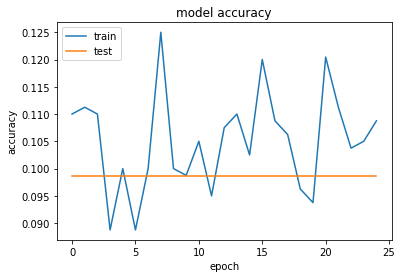

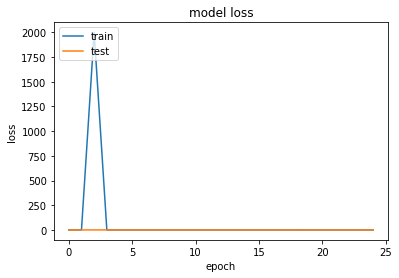

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Print the final train and validation loss and accuracy. Print confusion matrix and classification report for the validation dataset. Analyse and report the best and worst performing class.

In [ ]:
train_loss,train_acc  = model.evaluate(train_generator)
test_loss,test_acc   = model.evaluate(validation_generator)
print('Train accuracy: %.3f, Test accuracy: %.3f' % (train_acc, test_acc))
#print('Train loss: %.3f, Test loss: %.3f' % (train_loss, test_loss)

123/123 [==============================] - 5s 41ms/step - loss: 2.3892 - accuracy: 0.0935
Train accuracy: 0.081, Test accuracy: 0.094


Print confusion matrix and classification report for the validation dataset.

In [ ]:
Y_pred = model.predict(validation_generator, 3925 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)   

Confusion Matrix
[[ 20  11   2 142   0  55   3 136  13   5]
 [ 18  15   1 159   0  60   3 124   9   6]
 [ 15  11   0 157   0  37   4 115   7  11]
 [ 19   7   1 144   0  71   4 126   9   5]
 [ 25  12   0 149   0  57   1 142  14   9]
 [ 25  14   0 145   0  58   2 126  14  10]
 [ 20   3   0 184   0  52   3 114   4   9]
 [ 14  11   1 167   0  53   2 151  13   7]
 [ 15   4   0 155   0  63   4 146   9   3]
 [ 18  12   0 163   0  44   1 133  14   5]]
Classification Report
              precision    recall  f1-score   support

   n01440764       0.11      0.05      0.07       387
   n02102040       0.15      0.04      0.06       395
   n02979186       0.00      0.00      0.00       357
   n03000684       0.09      0.37      0.15       386
   n03028079       0.00      0.00      0.00       409
   n03394916       0.11      0.15      0.12       394
   n03417042       0.11      0.01      0.01       389
   n03425413       0.12      0.36      0.17       419
   n03445777       0.08      0.02      0.04

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Analyse and report the best and worst performing class.
Based on the above, best performing class - n03425413?
worst performing class - Others

Print the two most incorrectly classified images for each class in the test dataset.

In [ ]:
#TBD

Hyperparameter Tuning- Build two more additional models by changing the following hyperparameters ONE at a time. Write the code for Model Building, Model Compilation, Model Training and Model Evaluation as given in the instructions above for each additional model. (1 + 1 = 2 marks)
1. Network Depth: Change the number of hidden layers and hidden units for each layer
2. Regularization: Train a model without regularization

In [ ]:
#TBD